In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Importing all the libraries that we need

import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential # For Model building
from tensorflow.keras.layers import Dense, Flatten # For Model building
from tensorflow.keras.utils import to_categorical #  formatting the label
from keras.datasets import cifar10 # For loading the dataset
from skimage.color import rgb2gray # For Image processing
from tensorflow.keras import regularizers # for applying the L2 regularization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import swish
from tensorflow.keras.initializers import HeNormal # Weight initializer best for the ReLU activation functions
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### a) Feed Foward Neural Network

In [3]:
# Loading the dataset

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)



170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [4]:
# Converting the RGB images to Gray scale images

X_train_new = rgb2gray(X_train)
X_test_new = rgb2gray(X_test)

print("Grayscale training data shape:", X_train_new.shape)


Grayscale training data shape: (50000, 32, 32)


In [5]:
# Normalizing the pixel values from 0 to 1

X_train_new = X_train_new / 255.0
X_test_new = X_test_new / 255.0


In [5]:
# Flattening the gray scale images to vectors
X_train_flattened = X_train_new.reshape(-1, 32*32) 
# Flattening each 32x32 image into a single 1D array of 1024 pixels
# Here '-1' helps to tell Numpy to automatically infer the no. of rows based on the total data size
X_test_flattened = X_test_new.reshape(-1, 32*32) 

X_train_flattened.shape
# To make it ready for the Feed Forward Neural Network 


(50000, 1024)

In [6]:
# One hot encoding of all the class labels since here we are doing a classification task

y_train_categ = to_categorical(y_train, num_classes=10)
y_test_categ = to_categorical(y_test, num_classes=10)

In [7]:
# Using the first 10,000 samples as validation set(using one of the  5 batches ie. out of 50000/5 = 10000 of training samples as validation set)
X_val, y_val = X_train_flattened[:10000], y_train_categ[:10000]
X_train_final, y_train_final = X_train_flattened[10000:], y_train_categ[10000:]


In [8]:
print(X_train_final.shape)
print(X_val.shape)

(40000, 1024)
(10000, 1024)


In [9]:
# Defining a function for counting the total no. of trainable parameters in the model
def count_parameters(model):
    return model.count_params()

In [10]:
# Function for plotting the training and validation loss across epochs & that helps in visualizing the overfitting / underfitting
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
# Function for measuring the time taking for the training
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


In [12]:
# now defining three different FNN architectures ( 3 hyper parameter combinations)
# FNN - 1 

def FNN1():
    model = Sequential([
        Dense(512, activation=swish, input_shape=(1024,)), # Swish activation function outperforms ReLu in deep networks
        BatchNormalization(), # Batch norm normalizes the activations to mean 0 and variance 1
        Dropout(0.4), # Randomly drops 40% of the neurons during the training to reduce overfitting
        Dense(256, activation=swish),
        BatchNormalization(),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# FNN - 2
def FNN2():
    model = Sequential([
        Dense(1024, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(0.0005), input_shape=(1024,)),
        LeakyReLU(alpha=0.1), # LeakyReLU improves the Standard ReLU by a small slope for the negative outputs
        Dense(512, kernel_initializer=HeNormal(), kernel_regularizer=regularizers.l2(0.0005)), # L2 regularizer helps in controlling the overfitting by penalizing the larger weights
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [14]:
# FNN - 3
def FNN3():
    model = Sequential([
        Dense(512, activation='selu', kernel_initializer='lecun_normal', input_shape=(1024,)), 
        #SELU - Scaled Exponential Linear unit  which works best with the lecun_normal initializer
        Dropout(0.2),
        Dense(256, activation='selu', kernel_initializer='lecun_normal'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [15]:
# Model Training and Evaluation

def train_and_evaluate_model(model_fn, model_name, X_train, y_train, X_val, y_val, epochs=30, batch_size=128):
    print(f"\nTraining {model_name}")
    model = model_fn()

    with Timer() as t:
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)

    train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    n_params = count_parameters(model)

    print(f"Training time: {t.interval:.2f} seconds")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Number of parameters: {n_params}")

    plot_loss(history, title=f"{model_name} Loss")
    
    return model, val_acc



Training FNN1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training time: 28.65 seconds
Train accuracy: 0.4675
Validation accuracy: 0.4166
Number of parameters: 661770


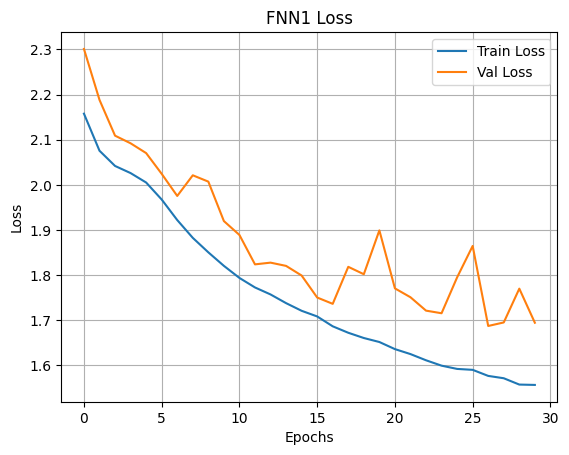


Training FNN2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Training time: 26.04 seconds
Train accuracy: 0.2813
Validation accuracy: 0.2795
Number of parameters: 1579530


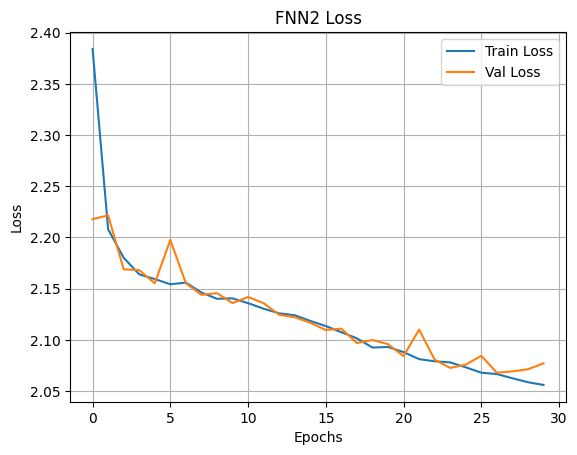


Training FNN3
Training time: 24.94 seconds
Train accuracy: 0.3779
Validation accuracy: 0.3557
Number of parameters: 658698


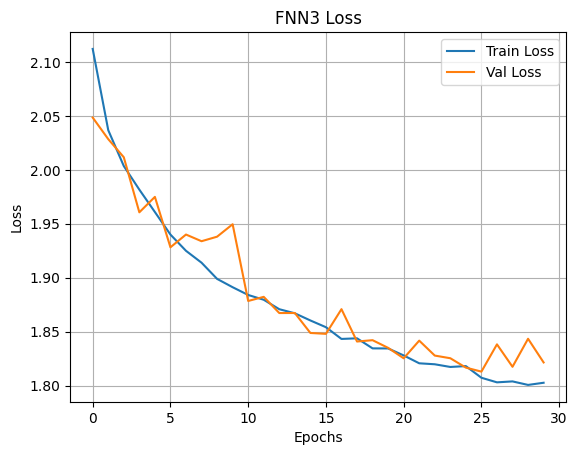

In [16]:
# Training three different hyper parameter sets

FNN1_inst, acc_FNN1 = train_and_evaluate_model(FNN1, "FNN1", X_train_final, y_train_final, X_val, y_val)
FNN2_inst, acc_FNN2 = train_and_evaluate_model(FNN2, "FNN2", X_train_final, y_train_final, X_val, y_val)
FNN3_inst, acc_FNN3 = train_and_evaluate_model(FNN3, "FNN3", X_train_final, y_train_final, X_val, y_val)


In [18]:
# Picking the best model based on the validation accuracy\

best_model = max([(FNN1_inst, acc_FNN1), (FNN2_inst, acc_FNN2), (FNN3_inst, acc_FNN3)], key=lambda x: x[1])[0]

test_loss, test_acc = best_model.evaluate(X_test_flattened, y_test_categ, verbose=0)

print("Test Accuracy of Best Model:", test_acc)


Test Accuracy of Best Model: 0.4034999907016754


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


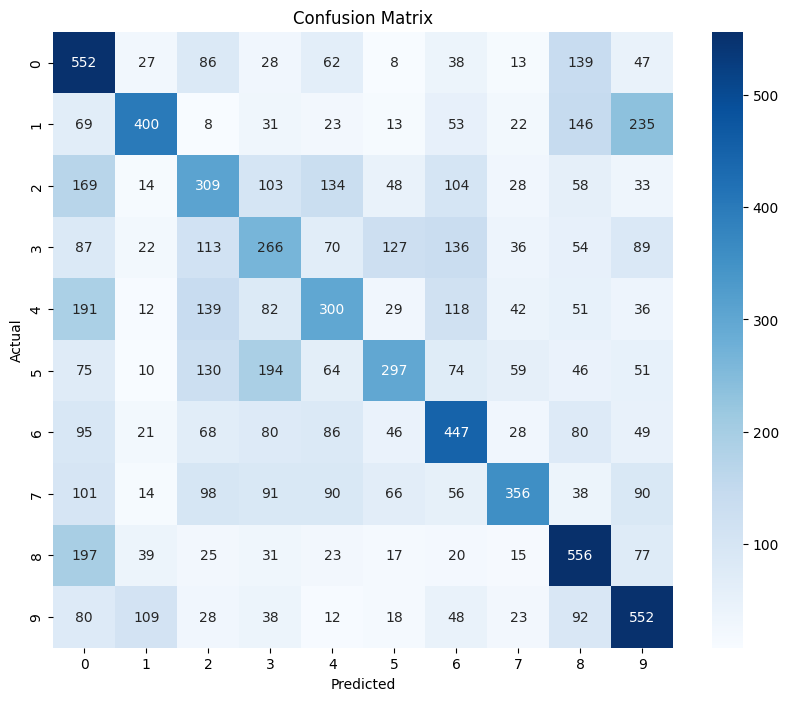

In [19]:
# Confusion Matrix for the best Model

y_pred = best_model.predict(X_test_flattened)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()

conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### b) Convolutional Neural Network

In [17]:
# importing all the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

from keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray


In [18]:
# Loading the Dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [20]:
# Normalizing the pixel values from 0 to 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [22]:
# Using the first 10,000 samples as validation set(using one of the  5 batches ie. out of 50000/5 = 10000 of training samples as validation set)
y_train_categ = to_categorical(y_train, num_classes=10)
y_test_categ = to_categorical(y_test, num_classes=10)

In [23]:
# Using the first 10,000 samples as validation set(using one of the  5 batches ie. out of 50000/5 = 10000 of training samples as validation set)
X_val, y_val = X_train[:10000], y_train_categ[:10000]
X_train_final, y_train_final = X_train[10000:], y_train_categ[10000:]



In [24]:
# Defining a function for counting the total no. of trainable parameters in the model
def count_parameters(model):
    return model.count_params()

In [25]:
# Function for plotting the training and validation loss across epochs & that helps in visualizing the overfitting / underfitting
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
from tensorflow.keras.callbacks import Callback

class EpochTimer(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.start_time)


In [27]:
# Function for measuring the time taking for the training
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

In [28]:
# now defining three different CNN architectures ( 3 hyper parameter combinations)
# CNN - 1 
def CNN1():
    model = Sequential([
        # Conv Block 1
        Conv2D(32, (5, 5), activation='relu', padding='same',
               strides=(2, 2), kernel_regularizer=regularizers.l2(0.0001052), input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2), padding='same'),

        # Conv Block 2
        Conv2D(32, (5, 5), activation='relu', padding='same',
               strides=(2, 2), kernel_regularizer=regularizers.l2(0.0001052)),
        MaxPooling2D((2, 2), padding='same'),

        # Conv Block 3
        Conv2D(32, (5, 5), activation='relu', padding='same',
               strides=(2, 2), kernel_regularizer=regularizers.l2(0.0001052)),
        MaxPooling2D((2, 2), padding='same'),

        Flatten(),

        # Dense Layers
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001052)),
        Dropout(0.1),
        Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.0001052)),
        Dropout(0.1),
        Dense(320, activation='relu', kernel_regularizer=regularizers.l2(0.0001052)),
        Dropout(0.1),

        # Output
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [29]:
# CNN - 2
def CNN2():
    model = Sequential([
        Conv2D(64, (3, 3), activation='tanh', padding='same',
               kernel_regularizer=regularizers.l2(0.0003316), input_shape=(32, 32, 3), strides=(1, 1)),
        MaxPooling2D((2, 2), padding='same'),

        Conv2D(64, (3, 3), activation='tanh', padding='same',
               kernel_regularizer=regularizers.l2(0.0003316), strides=(1, 1)),
        MaxPooling2D((2, 2), padding='same'),

        Flatten(),
        Dense(384, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),
        Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),
        Dense(384, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [30]:
# CNN - 3
def CNN3():
    model = Sequential([
        # Conv Block 1
        Conv2D(64, (3, 3), activation='tanh', padding='same',
               strides=(1, 1), kernel_regularizer=regularizers.l2(0.0003316), input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2), padding='same'),

        # Conv Block 2
        Conv2D(64, (3, 3), activation='tanh', padding='same',
               strides=(1, 1), kernel_regularizer=regularizers.l2(0.0003316)),
        MaxPooling2D((2, 2), padding='same'),

        Flatten(),

        # Dense Layers
        Dense(384, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),
        Dense(256, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),
        Dense(384, activation='tanh', kernel_regularizer=regularizers.l2(0.0003316)),
        Dropout(0.2),

        # Output
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [31]:
# Model Training and Evaluation
def train_and_evaluate_model(model_fn, model_name, X_train, y_train, X_val, y_val, epochs=30, batch_size=128):
    print(f"\nTraining {model_name}")
    model = model_fn()

    with Timer() as t:
        history = model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=0)

    train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
    val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
    n_params = count_parameters(model)

    print(f"Training time: {t.interval:.2f} seconds")
    print(f"Train accuracy: {train_acc:.4f}")
    print(f"Validation accuracy: {val_acc:.4f}")
    print(f"Number of parameters: {n_params}")

    plot_loss(history, title=f"{model_name} Loss")
    
    return model, val_acc



Training CNN 1
Training time: 45.20 seconds
Train accuracy: 0.7687
Validation accuracy: 0.6370
Number of parameters: 234058


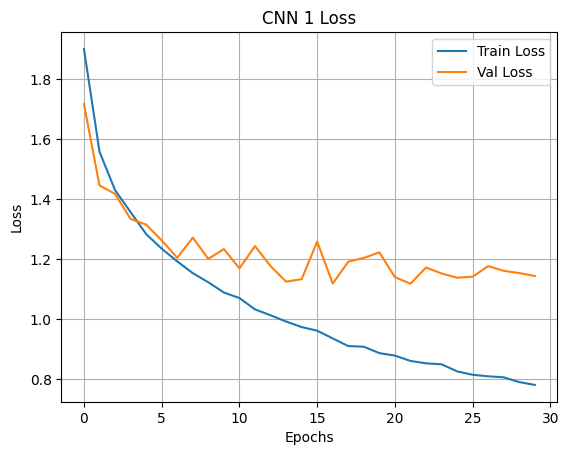


Training CNN 2
Training time: 79.06 seconds
Train accuracy: 0.8681
Validation accuracy: 0.6391
Number of parameters: 1813066


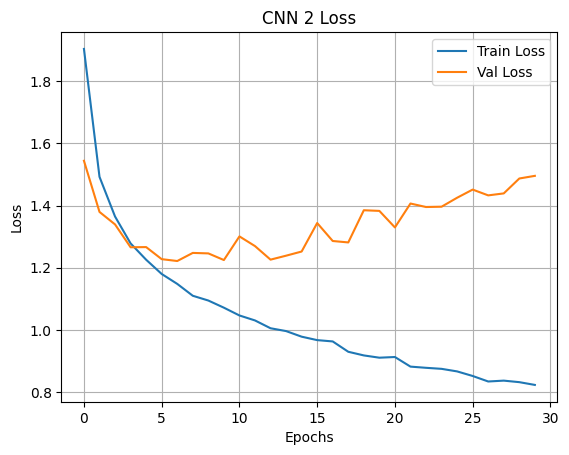


Training CNN 3
Training time: 76.18 seconds
Train accuracy: 0.8730
Validation accuracy: 0.6511
Number of parameters: 1813066


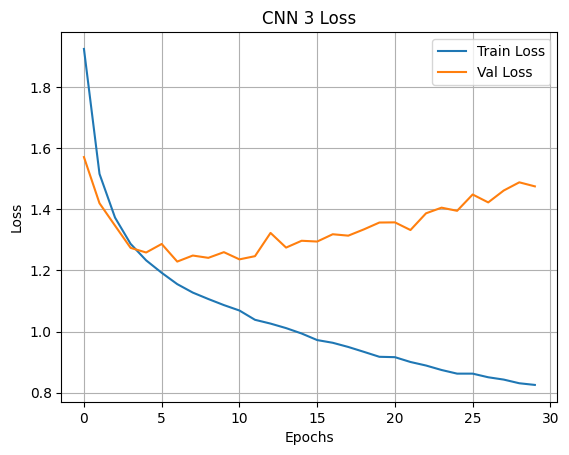

In [32]:
# Training three different hyper parameter sets
cnn1_model, acc1 = train_and_evaluate_model(CNN1, "CNN 1", X_train_final, y_train_final, X_val, y_val)
cnn2_model, acc2 = train_and_evaluate_model(CNN2, "CNN 2", X_train_final, y_train_final, X_val, y_val)
cnn3_model, acc3 = train_and_evaluate_model(CNN3, "CNN 3", X_train_final, y_train_final, X_val, y_val)


In [33]:
# Picking the best model based on the validation accuracy
best_cnn_model = max([(cnn1_model, acc1), (cnn2_model, acc2), (cnn3_model, acc3)], key=lambda x: x[1])[0]
test_loss, test_acc = best_cnn_model.evaluate(X_test_gray, y_test_categ, verbose=0)
print("Test Accuracy of Best CNN:", test_acc)

Test Accuracy of Best CNN: 0.6431999802589417


In [34]:
y_pred = best_cnn_model.predict(X_test_gray)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test.flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


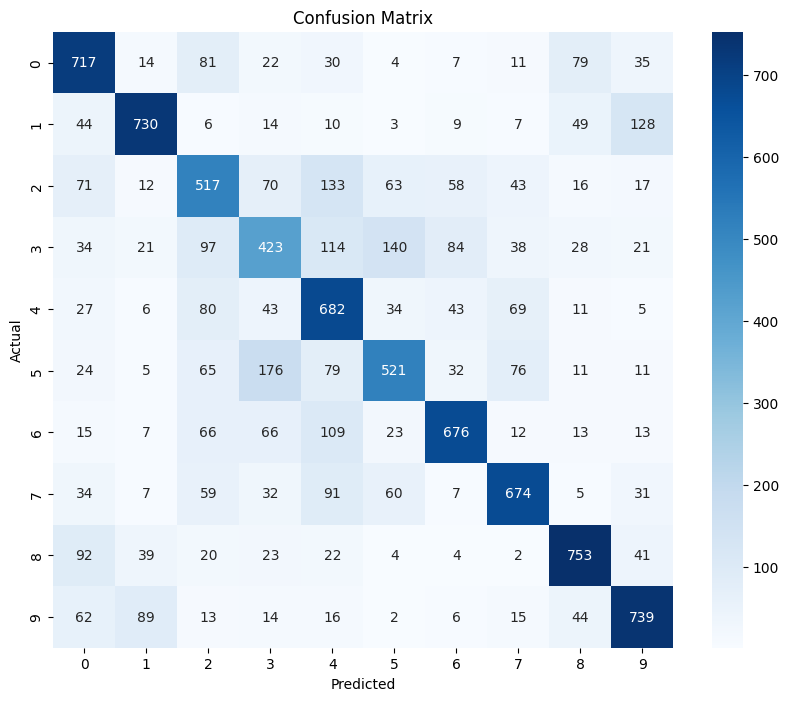

In [35]:
# Confusion Matrix for the best Model
conf_mat = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


- The FNN models achieved a very low accuracy ie. b/w 28 - 41% compared to the CNN models 63% - 65%
- The training time taken for CNN is slightly longer but this CNN model generalized better with few no. of parameters.
- FNNs didn't capture the spatial features of the images but the CNN models captured the local patterns ie. edges, textures effectively well.
- It's better to go for CNN models for the image classification tasks like CIFAR 10 from this study.

### c)

- Let's say that a self driving car is going through a busy street and suddenly a child crosses the road. If the car's AI model fails to recognize the child because sometimes it mistakenly takes that for a shadow and the car won't stop. It will lead to a terrible accident, which causes serious injuries/death. In the real world, one mistake like this causes a lot. That's the reason we have to make sure that the model understanding the obstacle and reacting to it instantly is very important.

- Even though if a self driving car performs better than a human driver, we should not start the operation right away in the streets. First, wer have to check the model many times. Testing should happen without any people nearby, then with fake people like some dummy structures, and finally with real people in a controlled zone. After it passes thousands of tests, in different places like empty roads, crowded streets, sunny days, rainy days then only the car should be allowed to drive freely. Safety is our first priority even though it's a genius machine.

- For object recognition tasks in self driving cars, the minimum acceptable threshold should be 99.9 % [100% may be over fitted model] for identifying the people walking in roads & cycles, vehicles such as (Cars, Buses, Trucks) [Missing a vehicle in the road may cause terrible collision among vehicles for the vehicles travelling in high speed], Traffic signals [Missing a red light in signals, will cause accident and also causes harm to other people who correctly followeed the traffic signals], Unexpected objects such as (Animals, Any obstacle like speed breakers, any cans etc.)

- This is dealing with human lives so we cannot take it easily like games or apps, a single mistake can cause multiple consequences.

- Today companies like Waymo are operating self driving taxis in San Francisco. They are capable of doing this because they tested this by running millions of miles without causing any harm/problems. These taxis also operately slowly to make sure that the people sitting inside the taxi should feel safe. So what's the key take away from Waymo is the model should prove the people through repeated & strict testing procedures without any compromises.